In [158]:
import torch
from torch import nn
from torch.nn import functional as F
from torchdiffeq import odeint
from torch.nn.parameter import Parameter
import gpytorch

from reggae.data_loaders import load_barenco_puma, DataHolder

from matplotlib import pyplot as plt

import tensorflow_probability as tfp
import numpy as np

f64 = np.float64

In [148]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)
f_observed = torch.tensor(f_observed)
data = (m_observed, f_observed)

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre)
noise_data = (σ2_m_pre, σ2_f_pre)

print(m_observed.shape)
display(m_df)
num_genes = m_observed.shape[1]
num_tfs = f_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
t_start = f64(0)
t_end = f64(1)
t = torch.linspace(t_start, t_end, granularity, dtype=torch.float64).view((-1, 1))
t_inducing = torch.linspace(t_start, t_end, 7, dtype=torch.float64).reshape((-1, 1))
print(t_inducing)

torch.Size([3, 5, 7])
tensor([[0.0000],
        [0.1667],
        [0.3333],
        [0.5000],
        [0.6667],
        [0.8333],
        [1.0000]], dtype=torch.float64)


,cARP1-0hrs.CEL,cARP1-2hrs.CEL,cARP1-4hrs.CEL,cARP1-6hrs.CEL,cARP1-8hrs.CEL,cARP1-10hrs.CEL,cARP1-12hrs.CEL,cARP2-0hrs.CEL,cARP2-2hrs.CEL,cARP2-4hrs.CEL,...,cARP2-8hrs.CEL,cARP2-10hrs.CEL,cARP2-12hrs.CEL,cARP3-0hrs.CEL,cARP3-2hrs.CEL,cARP3-4hrs.CEL,cARP3-6hrs.CEL,cARP3-8hrs.CEL,cARP3-10hrs.CEL,cARP3-12hrs.CEL
DDB2,7.593549,9.122439,10.192915,10.154778,10.103455,9.529804,9.567770,7.464445,8.611248,9.255834,...,8.149388,9.367364,9.342251,7.353484,7.665469,9.798868,9.345199,8.757635,8.357981,9.026733
BIK,2.905667,6.756250,8.154665,8.222898,8.074595,7.026262,7.001658,4.649182,5.926949,7.346142,...,4.659069,6.772798,7.005289,5.204797,4.139740,8.056000,7.122196,5.633847,4.488936,5.724764
TNFRSF10b,3.949437,7.283147,8.395333,8.147465,8.456766,7.370946,7.409659,3.828976,6.362601,7.576429,...,5.897853,6.975229,7.280981,4.822874,5.389953,7.749164,7.387181,6.083331,6.024036,6.771154
p21,1.268160,7.375613,9.600847,8.485615,8.134573,7.045323,7.171770,-0.094250,6.530376,7.910253,...,4.803834,6.971544,6.890152,1.397808,6.120564,8.724741,7.821537,6.483512,5.945312,6.653475
SESN1,6.354029,7.703226,8.818485,8.608104,8.803210,7.860224,7.981910,6.613610,7.371426,7.885798,...,6.658747,7.583440,7.503870,6.158661,6.178353,8.384142,7.993519,7.102504,6.990250,7.327648


In [198]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y):
        super(GP, self).__init__(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        rbf = gpytorch.kernels.RBFKernel(eps=0.1) # eps is min lengthscale
        rbf.lengthscale = f64(0.15)
        self.covar_module = gpytorch.kernels.ScaleKernel(rbf)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ODEModel(nn.Module):
    """
    Description blah
    Parameters
    ----------
    x_dim : int
    Dimension of x values. Currently only works for dimension of 1.
    z_dim : int
    Dimension of latent variable z. Contains [L0, z_].

    h_dim : int
    Dimension of hidden layer in odefunc.
    y_dim : int
    Dimension of y values.

    L_dim : int
    Dimension of latent state L.
    """
    def __init__(self, num_genes, num_tfs, t, t_inducing):
        super(ODEModel, self).__init__()
        self.num_genes = num_genes
        self.num_tfs = num_tfs
        self.num_inducing = 7
        self.t = t
        self.inducing_sources = t_inducing
        # t_1, t_2 = get_time_square(t, 100)
        # self.t_dist = t_1-t_2
        self.decay_rate = Parameter(0.5*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.basal_rate = Parameter(torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.w = Parameter(torch.ones((self.num_genes, self.num_tfs), dtype=torch.float64))
        self.w_0 = Parameter(torch.ones((self.num_tfs), dtype=torch.float64))
        self.inducing_targets = Parameter(torch.randn(self.num_inducing, dtype=torch.float64))
        self.gp = GP(self.inducing_sources.view(-1), self.inducing_targets)
        self.nfe = 0

    def forward(self, t, h):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor
            Shape (num_genes, 1)
        Returns
        -------
        Returns mu and sigma for output distribution. Both have shape
        (batch_size, num_points, y_dim).
        """
        self.nfe = 0
        num_times = t.size()


        # Integrate forward from the batch of initial positions z.
        h = odeint(self.odefunc, h, t, method='dopri5') # shape (num_genes, num_times, 1
        return torch.transpose(h, 0, 1)

    def odefunc(self, t, h):
        self.nfe += 1
        # print(t)

        # h is of shape (num_genes, 1)
        decay = torch.multiply(self.decay_rate.view(-1), h.view(-1)).view(-1, 1)

        p = self.get_tfs(t)

        Gp = self.G(p).view(-1, 1)
        # print(self.basal_rate, Gp, decay)

        return self.basal_rate + Gp - decay

    def get_tfs(self, at):
        self.gp.set_train_data(self.inducing_sources, self.inducing_targets)
        f_mvn = self.gp(self.inducing_sources) #TODO: remove
        self.gp.eval()

        f_mvn = self.gp(at.view(-1))
        self.gp.train()

        return f_mvn.mean #exand dims 0

    def G(self, p):
        p_pos = torch.log(1+torch.exp(p)) # positivity constraint
        interactions = torch.matmul(self.w, torch.log(p_pos+1e-50)) + self.w_0 #(TODO)
        return torch.sigmoid(interactions) # TF Activation Function (sigmoid)

    def latent(self, t):
        self.gp.eval()
        f_mvn = self.gp(t)
        return torch.log(1+torch.exp(f_mvn.mean))

    def train(self, mode=True):
        self.gp.train(mode)
        super().train(mode)

In [199]:
model = ODEModel(num_genes, num_tfs, t, t_inducing)
print(len(list(model.parameters())))

9


torch.Size([5, 7]) torch.Size([5, 7])
Epoch 1/30 - Loss: 1.444  b: 1.00 d 0.50 λ: 0.150 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 2/30 - Loss: 1.360  b: 1.10 d 0.40 λ: 0.165 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 3/30 - Loss: 1.294  b: 1.20 d 0.30 λ: 0.180 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 4/30 - Loss: 1.246  b: 1.30 d 0.20 λ: 0.196 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 5/30 - Loss: 1.215  b: 1.40 d 0.10 λ: 0.213 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 6/30 - Loss: 1.197  b: 1.49 d 0.01 λ: 0.230 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 7/30 - Loss: 1.186  b: 1.58 d -0.07 λ: 0.248 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 8/30 - Loss: 1.179  b: 1.67 d -0.13 λ: 0.265 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 9/30 - Loss: 1.171  b: 1.75 d -0.16 λ: 0.283 noise: 0.693
torch.Size([5, 7]) torch.Size([5, 7])
Epoch 10/30 - Loss: 1.161  b: 1.81 d -0.16 λ: 0.30

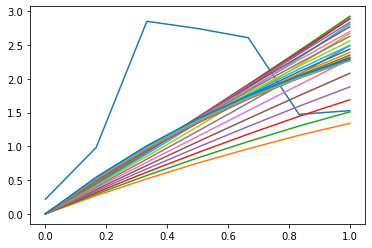

In [200]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
loss_fn = torch.nn.MSELoss()

def train():
    epochs = 30
    basalrates = list()
    decayrates = list()
    lengthscales = list()
    plt.figure()
    plt.plot(t_inducing, m_observed[0,0], label='real')

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Output from model
        initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
        output = torch.squeeze(model(t_inducing.view(-1), initial_value))
        print(output.shape, m_observed[0].shape)
        # Calc loss and backprop gradients
        loss = loss_fn(output, m_observed[0])

        loss.backward()
        print('Epoch %d/%d - Loss: %.3f  b: %.2f d %.2f λ: %.3f noise: %.3f' % (
            epoch + 1, epochs, loss.item(),
            model.basal_rate[0].item(),
            model.decay_rate[0].item(),
            model.gp.covar_module.base_kernel.lengthscale.item(),
            model.gp.likelihood.noise.item()
        ))
        optimizer.step()

        basalrates.append(model.basal_rate.detach().numpy())
        decayrates.append(model.decay_rate.detach().numpy())
        lengthscales.append(model.gp.covar_module.base_kernel.lengthscale.item())
        plt.plot(t_inducing, output[0].detach().numpy(), label='epoch'+str(epoch))


    return output, (basalrates, decayrates, lengthscales)

outputs, params = train()

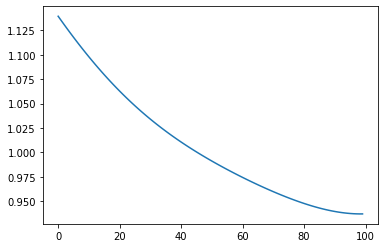

In [201]:
plt.plot(model.latent(t).detach())

[0.056279368698596954, 0.051276158541440964, 0.046967290341854095, 0.0432719960808754, 0.040163684636354446, 0.03757946193218231, 0.03530862554907799, 0.033388808369636536, 0.031882207840681076, 0.030604226514697075]
(10,)
[[2.40601593]
 [2.40601593]
 [2.40601593]
 [2.40601593]
 [2.40601593]
 [2.40601593]
 [2.40601593]
 [2.40601593]
 [2.40601593]
 [2.40601593]]


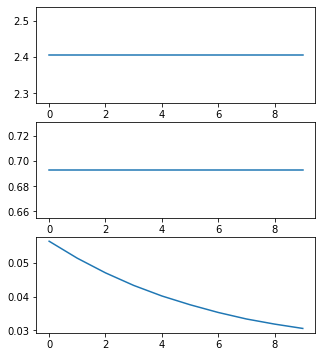

In [181]:
plt.figure(figsize=(5, 6))
basal, decay, lengthscale = params
print(lengthscale)
basals = np.array(basal)
decays = np.array(decay)
lengthscales = np.array(lengthscale)
print(lengthscales.shape)
plt.subplot(311)
print(basals[:,0])
plt.plot(basals[:,0])
# plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
# plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
# plt.ylim(1, 1.2)

In [62]:
m_observed[0].shape

(5, 7)